Processing EEG and MEG data in Python using mne-python
=============================

###Authors:
* Mainak Jas (plotly figures)
* Alexandre Gramfort and Denis Engemann (original tutorial)

[MNE-Python](http://martinos.org/mne/stable/mne-python.html) is a software package for processing [MEG](http://en.wikipedia.org/wiki/Magnetoencephalography)/[EEG](http://en.wikipedia.org/wiki/Electroencephalography) data.

The first step to get started, ensure that mne-python is installed on your computer:

In [1]:
import mne  # If this line returns an error, uncomment the following line
# !easy_install mne --upgrade

Let us make the plots inline and import numpy to access the array manipulation routines

In [2]:
# add plot inline in the page
%matplotlib inline
import numpy as np

We set the log-level to 'WARNING' so the output is less verbose

In [3]:
mne.set_log_level('WARNING')

## Access raw data

Now we import the MNE sample dataset. If you don't already have it, it will be downloaded automatically (but be patient as it is approximately 2GB large)

In [4]:
from mne.datasets import sample
data_path = sample.data_path()

raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'

Read data from file:

In [5]:
raw = mne.io.Raw(raw_fname, preload=False)
print(raw)

<RawFIF  |  n_channels x n_times : 376 x 41700>


The data gets stored in the `Raw` object. If `preload` is `False`, only the header information is loaded into memory and the data is loaded on-demand, thus saving RAM.

The `info` dictionary contains all measurement related information: the list of bad channels, channel locations, sampling frequency, subject information etc. The `info` dictionary is also available to the `Epochs` and `Evoked` objects.

In [6]:
print(raw.info)

<Info | 20 non-empty fields
    bads : list | MEG 2443, EEG 053
    buffer_size_sec : numpy.float64 | 13.3196808772
    ch_names : list | MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, ...
    chs : list | 376 items (EOG: 1, EEG: 60, STIM: 9, GRAD: 204, MAG: 102)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : dict | 3 items
    dig : list | 146 items
    events : list | 0 items
    file_id : dict | 4 items
    filename : unicode | /home/main.../sample_audvis_filt-0-40_raw.fif
    highpass : float | 0.10000000149
    hpi_meas : list | 1 items
    hpi_results : list | 1 items
    lowpass : float | 40.0
    meas_date : numpy.ndarray | 2002-12-03 20:01:10
    meas_id : dict | 4 items
    nchan : int | 376
    projs : list | PCA-v1: off, PCA-v2: off, PCA-v3: off, ...
    sfreq : float | 150.153747559
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    experimenter : NoneType
 

Look at the channels in raw:

In [7]:
print(raw.ch_names[:5])

['MEG 0113', 'MEG 0112', 'MEG 0111', 'MEG 0122', 'MEG 0123']


The raw object returns a numpy array when sliced

In [8]:
data, times = raw[:, :10]
print(data.shape)

(376, 10)


Read and plot a segment of raw data

In [9]:
start, stop = raw.time_as_index([100, 115])  # 100 s to 115 s data segment
data, times = raw[:306, start:stop]
print(data.shape)
print(times.shape)
print(times.min(), times.max())

(306, 2252)
(2252,)
(99.997504185773124, 114.98880501309083)


MNE-Python provides a set of helper functions to select the channels by type (see [here](http://imaging.mrc-cbu.cam.ac.uk/meg/VectorviewDescription#Magsgrads) for a brief overview of channel types in an MEG system). For example, to select only the magnetometer channels, we do this:

In [10]:
picks = mne.pick_types(raw.info, meg='mag', exclude=[])
print(picks)

[  2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53
  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 101 104 107
 110 113 116 119 122 125 128 131 134 137 140 143 146 149 152 155 158 161
 164 167 170 173 176 179 182 185 188 191 194 197 200 203 206 209 212 215
 218 221 224 227 230 233 236 239 242 245 248 251 254 257 260 263 266 269
 272 275 278 281 284 287 290 293 296 299 302 305]


Similarly, `mne.mne.pick_channels_regexp` lets you pick channels using an arbitrary regular expression and `mne.pick_channels` allows you to pick channels by name. Bad channels are excluded from the selection by default.

Now, we can use picks to select magnetometer data and plot it. The matplotlib graph can be converted into an interactive one using Plotly with just one line of code:

In [11]:
picks = mne.pick_types(raw.info, meg='mag', exclude=[])
data, times = raw[picks[:10], start:stop]

import matplotlib.pyplot as plt
import plotly.plotly as py

plt.plot(times, data.T)
plt.xlabel('time (s)')
plt.ylabel('MEG data (T)')

update = dict(layout=dict(showlegend=True), data=[dict(name=raw.info['ch_names'][p]) for p in picks[:10]])
py.iplot_mpl(plt.gcf(), update=update)

But, we can also use MNE-Python's interactive data browser to get a better visualization:

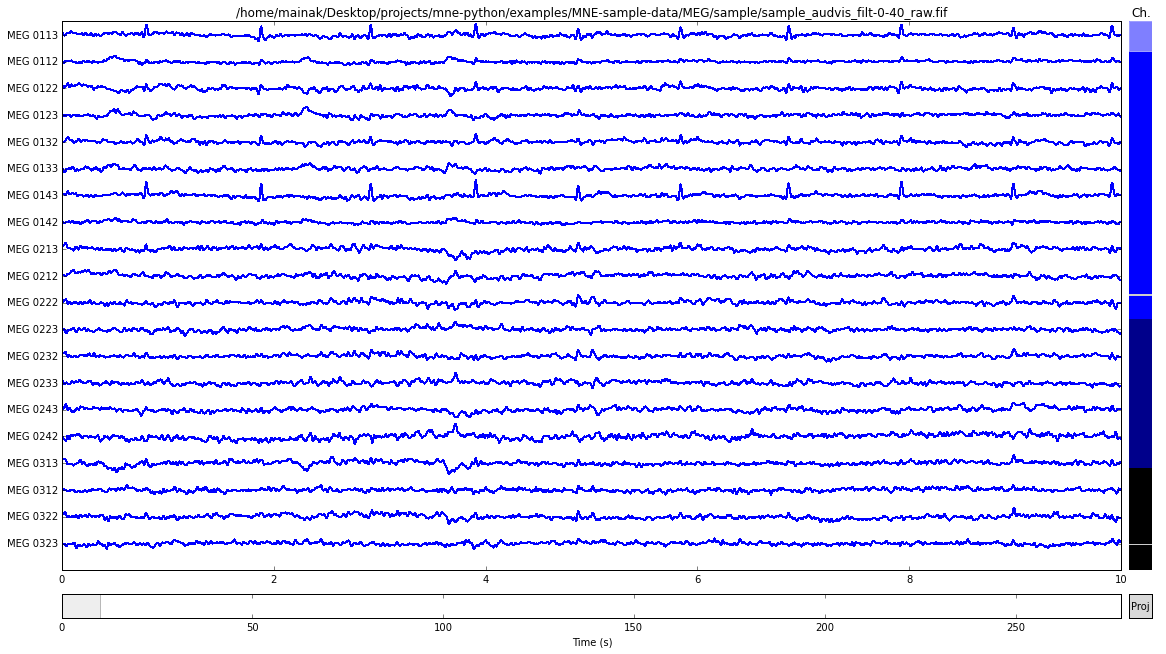

In [12]:
raw.plot();

Let us do the same using Plotly. First, we import the required classes

In [13]:
from plotly import tools
from plotly.graph_objs import Layout, YAxis, Scatter, Annotation, Annotations, Data, Figure, Marker, Font

Now we get the data for the first 10 seconds in 20 gradiometer channels

In [14]:
picks = mne.pick_types(raw.info, meg='grad', exclude=[])
start, stop = raw.time_as_index([0, 10])

n_channels = 20
data, times = raw[picks[:n_channels], start:stop]
ch_names = [raw.info['ch_names'][p] for p in picks[:n_channels]]

Finally, we create the plotly graph by creating a separate subplot for each channel

In [15]:
step = 1. / n_channels
kwargs = dict(domain=[1 - step, 1], showticklabels=False, zeroline=False, showgrid=False)

# create objects for layout and traces
layout = Layout(yaxis=YAxis(kwargs), showlegend=False)
traces = [Scatter(x=times, y=data.T[:, 0])]

# loop over the channels
for ii in range(1, n_channels):
        kwargs.update(domain=[1 - (ii + 1) * step, 1 - ii * step])
        layout.update({'yaxis%d' % (ii + 1): YAxis(kwargs), 'showlegend': False})
        traces.append(Scatter(x=times, y=data.T[:, ii], yaxis='y%d' % (ii + 1)))

# add channel names using Annotations
annotations = Annotations([Annotation(x=-0.06, y=0, xref='paper', yref='y%d' % (ii + 1),
                                      text=ch_name, font=Font(size=9), showarrow=False)
                          for ii, ch_name in enumerate(ch_names)])
layout.update(annotations=annotations)

# set the size of the figure and plot it
layout.update(autosize=False, width=1000, height=600)
fig = Figure(data=Data(traces), layout=layout)
py.iplot(fig, filename='shared xaxis')

We can look at the list of bad channels from the ``info`` dictionary

In [16]:
raw.info['bads']

[u'MEG 2443', u'EEG 053']

Save a segment of 150s of raw data (MEG only):

In [17]:
picks = mne.pick_types(raw.info, meg=True, eeg=False, stim=True, exclude=[])
raw.save('sample_audvis_meg_raw.fif', tmin=0., tmax=150., picks=picks, overwrite=True)

Filtering is as simple as providing the low and high cut-off frequencies. We can use the `n_jobs` parameter to filter the channels in parallel.

In [18]:
raw_beta = mne.io.Raw(raw_fname, preload=True)  # reload data with preload for filtering

# keep beta band
raw_beta.filter(13.0, 30.0, method='iir', n_jobs=-1)

# save the result
raw_beta.save('sample_audvis_beta_raw.fif', overwrite=True)

# check if the info dictionary got updated
print(raw_beta.info['highpass'], raw_beta.info['lowpass'])

(13.0, 30.0)


## Define and read epochs

First extract events. Events are typically extracted from the trigger channel, which in our case is `STI 014`. In the sample dataset, there are [5 possible event-ids](http://martinos.org/mne/stable/manual/sampledata.html#babdhifj): 1, 2, 3, 4, 5, and 32.

In [19]:
events = mne.find_events(raw, stim_channel='STI 014')
print(events[:5])  # events is a 2d array

[[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]]


Events is a 2d array where the first column contains the sample index when the event occurred. The second column contains the value of the trigger channel immediately before the event occurred. The third column contains the event-id.

Therefore, there are around 73 occurences of the event with event-id 2.

In [20]:
len(events[events[:, 2] == 2])

73

And the total number of events in the dataset is 319

In [21]:
len(events)

319

We can index the channel name to find it's position among all the available channels

In [22]:
raw.ch_names.index('STI 014')

312

In [23]:
raw = mne.io.Raw(raw_fname, preload=True)  # reload data with preload for filtering
raw.filter(1, 40, method='iir')

Let us plot the trigger channel as an interactive plot:

In [24]:
d, t = raw[raw.ch_names.index('STI 014'), :]
plt.plot(d[0,:1000])
py.iplot_mpl(plt.gcf())

We can also plot the events using the `plot_events` function.

In [25]:
event_ids = ['aud_l', 'aud_r', 'vis_l', 'vis_r', 'smiley', 'button']
fig = mne.viz.plot_events(events, raw.info['sfreq'], raw.first_samp, show=False)

# convert plot to plotly
update = dict(layout=dict(showlegend=True), data=[dict(name=e) for e in event_ids])
py.iplot_mpl(plt.gcf(), update=update)

Define epochs parameters:

In [26]:
event_id = dict(aud_l=1, aud_r=2)  # event trigger and conditions
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)

In [27]:
event_id

{'aud_l': 1, 'aud_r': 2}

Mark two channels as bad:

In [28]:
raw.info['bads'] = ['MEG 2443', 'EEG 053']
print(raw.info['bads'])

['MEG 2443', 'EEG 053']


The variable raw.info[‘bads’] is just a python list.

Pick the good channels:

In [29]:
picks = mne.pick_types(raw.info, meg=True, eeg=True, eog=True,
                       stim=False, exclude='bads')

Alternatively one can restrict to magnetometers or gradiometers with:

In [30]:
mag_picks = mne.pick_types(raw.info, meg='mag', eog=True, exclude='bads')
grad_picks = mne.pick_types(raw.info, meg='grad', eog=True, exclude='bads')

Define the baseline period for baseline correction:

In [31]:
baseline = (None, 0)  # means from the first instant to t = 0

Define peak-to-peak rejection parameters for gradiometers, magnetometers and EOG. If the data in any channel exceeds these thresholds, the corresponding epoch will be rejected:

In [32]:
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)

Now we create epochs from the `raw` object. The epochs object allows storing data of fixed length around the events which are supplied to the `Epochs` constructor. 

In [33]:
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=baseline, reject=reject)

Now let us compute what channels contribute to epochs rejection. The drop log stores the epochs dropped and the reason they were dropped. Refer to the MNE-Python documentation for further details:

In [34]:
from mne.fixes import Counter

# drop bad epochs
epochs.drop_bad_epochs()
drop_log = epochs.drop_log

# calculate percentage of epochs dropped for each channel
perc = 100 * np.mean([len(d) > 0 for d in drop_log if not any(r in ['IGNORED'] for r in d)])
scores = Counter([ch for d in drop_log for ch in d if ch not in ['IGNORED']])
ch_names = np.array(list(scores.keys()))
counts = 100 * np.array(list(scores.values()), dtype=float) / len(drop_log)
order = np.flipud(np.argsort(counts))

And now we can use Plotly to show the statistics:

In [35]:
from plotly.graph_objs import Data, Layout, Bar, YAxis, Figure

data = Data([
    Bar(
        x=ch_names[order],
        y=counts[order]
    )
])
layout = Layout(title='Drop log statistics', yaxis=YAxis(title='% of epochs rejected'))

fig = Figure(data=data, layout=layout)
py.iplot(fig)

And if you want to keep all the information about the data you can save your epochs in a fif file:

In [36]:
epochs.save('sample-epo.fif')

## Average the epochs to get [Event-related Potential](http://en.wikipedia.org/wiki/Event-related_potential)

In [37]:
evoked = epochs.average()

Now let's visualize our event-related potential / field:

In [38]:
fig = evoked.plot(show=False)  # butterfly plots
update = dict(layout=dict(showlegend=False), data=[dict(name=raw.info['ch_names'][p]) for p in picks[:10]])
py.iplot_mpl(fig, update=update)

The draw time for this plot will be slow for clients without much RAM.


/home/mainak/anaconda/lib/python2.7/site-packages/plotly-1.6.17-py2.7.egg/plotly/plotly/plotly.py:1261: UserWarning:

Estimated Draw Time Slow



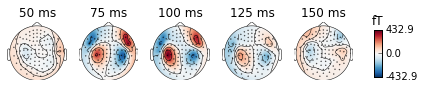

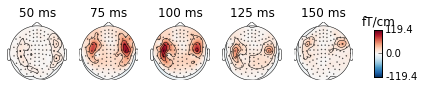

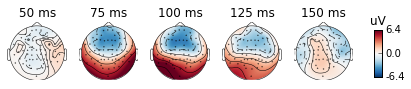

In [39]:
# topography plots
evoked.plot_topomap(times=np.linspace(0.05, 0.15, 5), ch_type='mag');
evoked.plot_topomap(times=np.linspace(0.05, 0.15, 5), ch_type='grad');
evoked.plot_topomap(times=np.linspace(0.05, 0.15, 5), ch_type='eeg');

### Get single epochs for one condition:

Syntax is `epochs[condition]`

In [40]:
epochs_data = epochs['aud_l'].get_data()
print(epochs_data.shape)

(55, 365, 106)


epochs_data is a 3D array of dimension (55 epochs, 365 channels, 106 time instants).

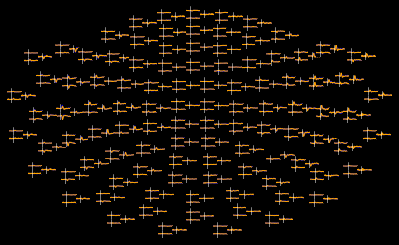

In [41]:
evokeds = [epochs[k].average() for k in event_id]
from mne.viz import plot_topo
layout = mne.find_layout(epochs.info)
plot_topo(evokeds, layout=layout, color=['blue', 'orange']);

## Compute noise covariance

In [42]:
noise_cov = mne.compute_covariance(epochs, tmax=0.)
print(noise_cov.data.shape)

(364, 364)


/home/mainak/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1644: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.



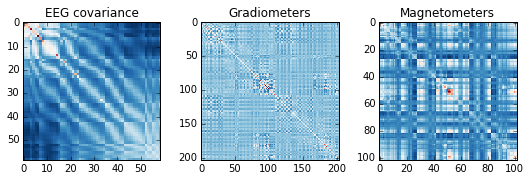

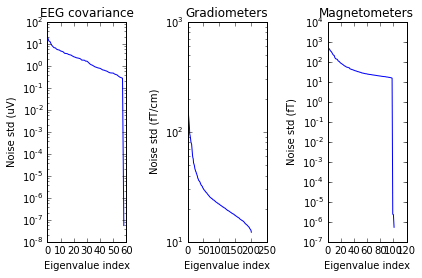

In [43]:
fig = mne.viz.plot_cov(noise_cov, raw.info)

## Inverse modeling: [dSPM](http://www.sciencedirect.com/science/article/pii/S0896627300811381) on evoked and raw data

Inverse modeling can be used to estimate the source activations which explain the sensor-space data.

First, Import the required functions:

In [44]:
from mne.forward import read_forward_solution
from mne.minimum_norm import (make_inverse_operator, apply_inverse,
                              write_inverse_operator)

## Read the forward solution and compute the inverse operator

The forward solution describes how the currents inside the brain will manifest in sensor-space. This is required for computing the inverse operator which describes the transformation from sensor-space data to source space:

In [45]:
fname_fwd = data_path + '/MEG/sample/sample_audvis-meg-oct-6-fwd.fif'
fwd = mne.read_forward_solution(fname_fwd, surf_ori=True)

# Restrict forward solution as necessary for MEG
fwd = mne.pick_types_forward(fwd, meg=True, eeg=False)

# make an M/EEG, MEG-only, and EEG-only inverse operators
info = evoked.info
inverse_operator = make_inverse_operator(info, fwd, noise_cov,
                                         loose=0.2, depth=0.8)

write_inverse_operator('sample_audvis-meg-oct-6-inv.fif',
                       inverse_operator)

## Compute inverse solution

Now we can use the inverse operator and apply to MEG data to get the inverse solution

In [46]:
method = "dSPM"
snr = 3.
lambda2 = 1. / snr ** 2
stc = apply_inverse(evoked, inverse_operator, lambda2,
                    method=method, pick_ori=None)
print(stc)

<SourceEstimate  |  7498 vertices, subject : sample, tmin : -199.795213158 (ms), tmax : 499.488032896 (ms), tstep : 6.65984043861 (ms), data size : 7498 x 106>


In [47]:
stc.data.shape

(7498, 106)

Show the result:

In [48]:
import surfer
surfer.set_log_level('WARNING')

subjects_dir = data_path + '/subjects'
brain = stc.plot(surface='inflated', hemi='rh', subjects_dir=subjects_dir)
brain.set_data_time_index(45)
brain.scale_data_colormap(fmin=8, fmid=12, fmax=15, transparent=True)
brain.show_view('lateral')

/home/mainak/.local/lib/python2.7/site-packages/pysurfer-0.5.dev-py2.7.egg/surfer/viz.py:1563: FutureWarning:

comparison to `None` will result in an elementwise object comparison in the future.



((-7.0167092985348768e-15, 90.0, 518.46453857421875, array([ 0.,  0.,  0.])),
 -90.0)

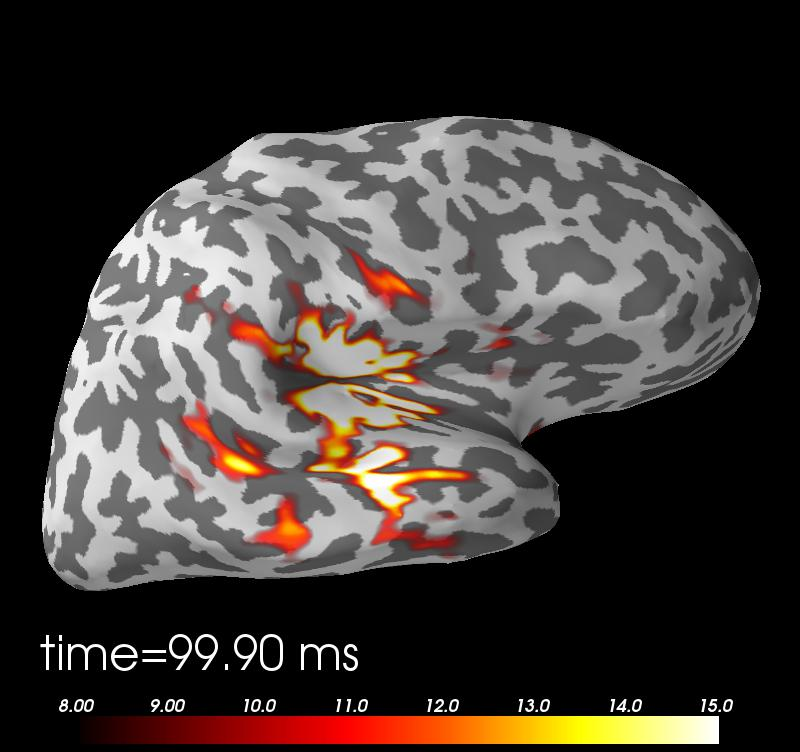

In [49]:
brain.save_image('dspm.jpg')
brain.close()
from IPython.display import Image
Image(filename='dspm.jpg', width=600)

## Time-frequency analysis

In [50]:
from mne.time_frequency import tfr_morlet
freqs = np.arange(6, 30, 3)  # define frequencies of interest
n_cycles = freqs / 4.  # different number of cycle per frequency

power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False,
                   return_itc=False, decim=3, n_jobs=1)

Now let''s look at the power plots

/home/mainak/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



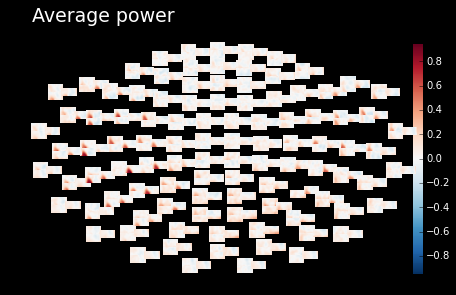

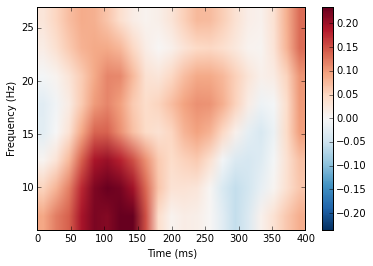

In [51]:
# Inspect power

power.plot_topo(baseline=(-0.5, 0), tmin=0, tmax=0.4, mode='logratio', title='Average power');
power.plot([82], baseline=(-0.5, 0), tmin=0, tmax=0.4, mode='logratio');

In [1]:
from IPython.display import display, HTML

display(HTML('<link href="//fonts.googleapis.com/css?family=Open+Sans:600,400,300,200|Inconsolata|Ubuntu+Mono:400,700" rel="stylesheet" type="text/css" />'))
display(HTML('<link rel="stylesheet" type="text/css" href="http://help.plot.ly/documentation/all_static/css/ipython-notebook-custom.css">'))

! pip install publisher --upgrade
import publisher
publisher.publish(
    'mne-tutorial.ipynb', '/ipython-notebooks/mne-tutorial', 'Plotly visualizations for MNE-Python to process MEG/EEG data', 
    'Create interactive visualizations using MNE-Python and Plotly')

Requirement already up-to-date: publisher in /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/publisher/publisher.py:50: UserWarning: Did you "Save" this notebook before running this command? Remember to save, always save.
  warnings.warn('Did you "Save" this notebook before running this command? '
